In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=42)

In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

0.9385964912280702

In [6]:
sgd = SGDClassifier(loss='hinge', max_iter=100, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

0.8596491228070176

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, 
                                                  test_size=0.2, random_state=42)

In [8]:
print(len(X_train), len(X_val))

364 91


In [9]:
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)
sgd.score(X_val, y_val)

0.8571428571428571

['mean perimeter' 'mean area']


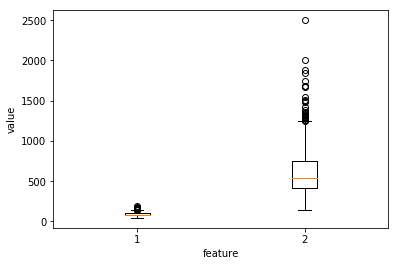

In [10]:
print(cancer.feature_names[[2,3]])
plt.boxplot(X_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [11]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w)    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        return w_grad

    def add_bias(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X] # 행렬의 맨 앞에 1로 채워진 열 벡터를 추가합니다
                
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, X, y, epochs=100, X_val=None, y_val=None):
        Xb = self.add_bias(X)                      # 편향을 위한 x_0 추가
        self.w = np.ones(X.shape[1]+1)             # 가중치를 초기화합니다
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(Xb)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(Xb[i])            # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = y[i] - a                     # 오차 계산
                w_grad = self.backprop(Xb[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 뺍니다
                w_grad[1:] -= self.l1 * np.sign(self.w[1:]) + self.l2 * self.w[1:]
                self.w += self.lr * w_grad         # 가중치 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(X_val, y_val)
    
    def predict(self, X):
        Xb = self.add_bias(X)                     # 편향을 위한 x_0 추가
        z = [self.forpass(x_i) for x_i in Xb]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w[1:])) + self.l2 / 2 * np.sum(self.w[1:]**2)
    
    def update_val_loss(self, X_val, y_val):
        if X_val is None:
            return
        Xb_val = self.add_bias(X_val)
        val_loss = 0
        for i in range(len(Xb_val)):
            z = self.forpass(Xb_val[i])    # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [12]:
layer1 = SingleLayer()
layer1.fit(X_train, y_train)
layer1.score(X_val, y_val)

0.9230769230769231

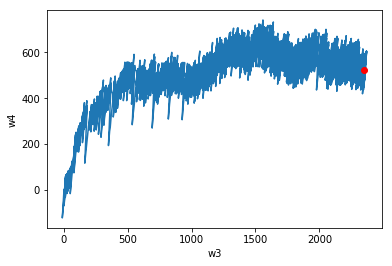

In [13]:
w3 = []
w4 = []
for w in layer1.w_history:
    w3.append(w[3])
    w4.append(w[4])
plt.plot(w3, w4)
plt.plot(w3[-1], w4[-1], 'ro')
plt.xlabel('w3')
plt.ylabel('w4')
plt.show()

In [14]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
X_train_scaled = (X_train - train_mean) / train_std

In [15]:
layer2 = SingleLayer()
layer2.fit(X_train_scaled, y_train)

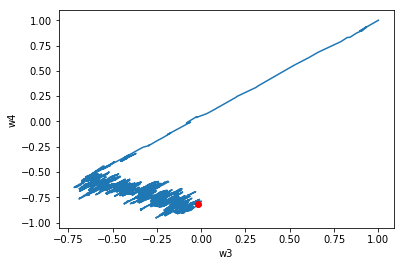

In [16]:
w3 = []
w4 = []
for w in layer2.w_history:
    w3.append(w[3])
    w4.append(w[4])
plt.plot(w3, w4)
plt.plot(w3[-1], w4[-1], 'ro')
plt.xlabel('w3')
plt.ylabel('w4')
plt.show()

In [17]:
layer2.score(X_val, y_val)

0.37362637362637363

In [18]:
val_mean = np.mean(X_val, axis=0)
val_std = np.std(X_val, axis=0)
X_val_scaled = (X_val - val_mean) / val_std

In [19]:
layer2.score(X_val_scaled, y_val)

0.967032967032967

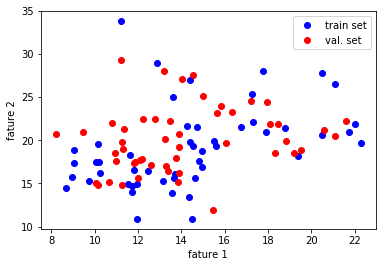

In [20]:
plt.plot(X_train[:50, 0], X_train[:50, 1], 'bo')
plt.plot(X_val[:50, 0], X_val[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

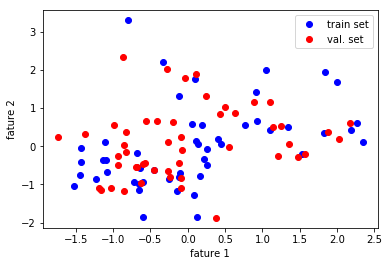

In [21]:
plt.plot(X_train_scaled[:50, 0], X_train_scaled[:50, 1], 'bo')
plt.plot(X_val_scaled[:50, 0], X_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

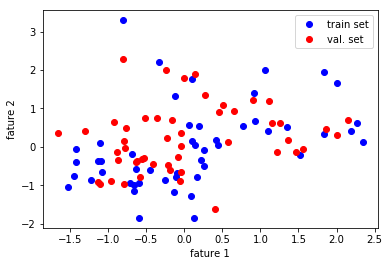

In [22]:
X_val_scaled = (X_val - train_mean) / train_std

plt.plot(X_train_scaled[:50, 0], X_train_scaled[:50, 1], 'bo')
plt.plot(X_val_scaled[:50, 0], X_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [23]:
layer2.score(X_val_scaled, y_val)

0.967032967032967

In [24]:
layer3 = SingleLayer()
layer3.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)

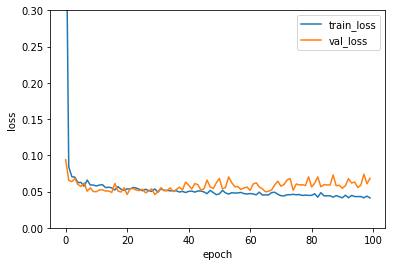

In [25]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [26]:
layer4 = SingleLayer()
layer4.fit(X_train_scaled, y_train, epochs=20)
layer4.score(X_val_scaled, y_val)

0.978021978021978

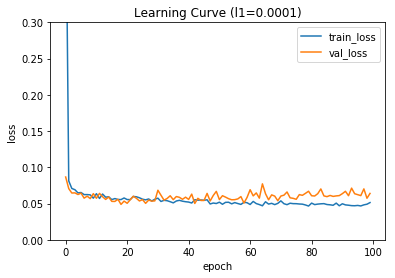

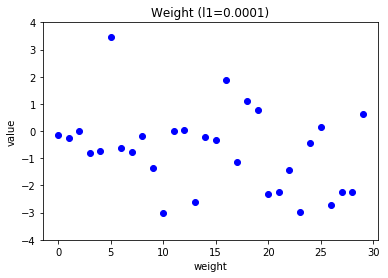

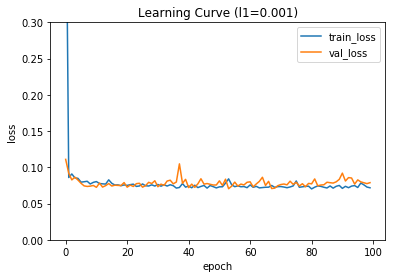

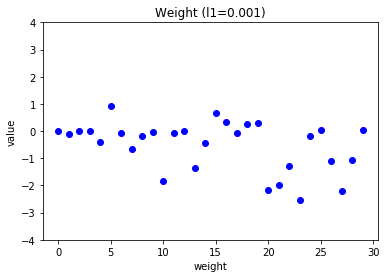

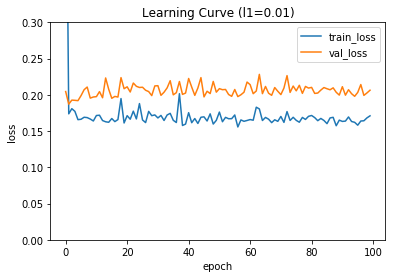

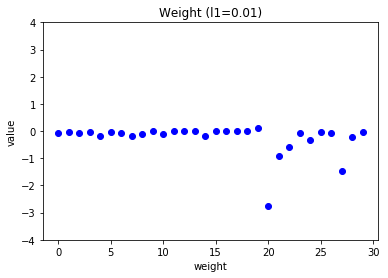

In [27]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w[1:], 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [28]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(X_train_scaled, y_train, epochs=50)
layer5.score(X_val_scaled, y_val)

0.978021978021978

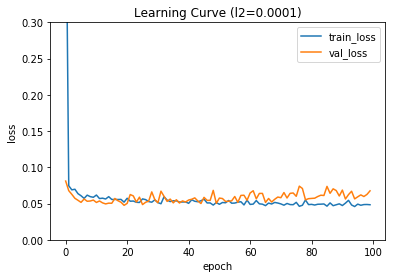

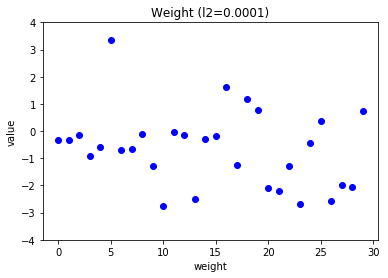

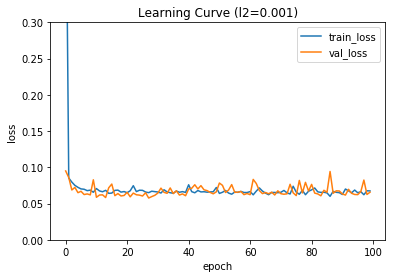

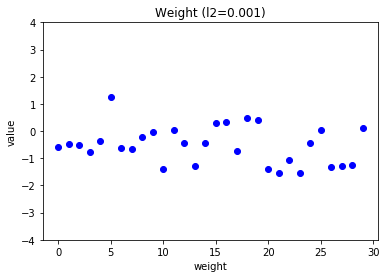

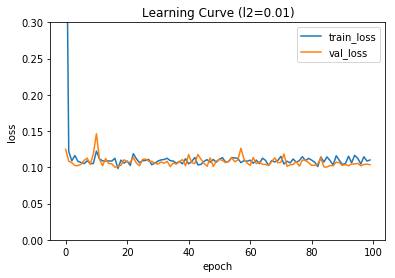

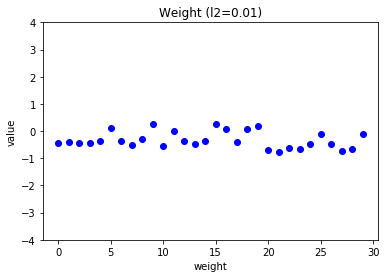

In [29]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w[1:], 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [30]:
layer6 = SingleLayer(l2=0.001)
layer6.fit(X_train_scaled, y_train, epochs=50)
layer6.score(X_val_scaled, y_val)

0.978021978021978

In [31]:
np.sum(layer6.predict(X_val_scaled) == y_val)

89

In [32]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, 
                    max_iter=100, tol=1e-3, random_state=42)
sgd.fit(X_train_scaled, y_train)
sgd.score(X_val_scaled, y_val)

0.978021978021978

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=42)
indexes = np.random.permutation(np.arange(len(X_train)))
X_train = X_train[indexes]
y_train = y_train[indexes]
validation_scores = []

In [34]:
k = 10
bins = len(X_train) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = X_train[start:end]
    val_target = y_train[start:end]
    
    train_index = list(range(0, start))+list(range(end, len(X_train)))
    train_fold = X_train[train_index]
    train_target = y_train[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2=0.001)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))

0.9733333333333334


In [35]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, 
                    max_iter=100, tol=1e-3, random_state=42)
scores = cross_validate(sgd, X_train, y_train, cv=10)
print(np.mean(scores['test_score']))

0.8618357487922707


In [36]:
type(scores)

sklearn.utils.deprecation.DeprecationDict

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, X_train, y_train, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.962657004830918


In [38]:
print(np.mean(scores['train_score']))

0.9899874768918838
